# Análisis de la red de Facebook
Este cuaderno contiene un análisis de redes sociales ejecutado principalmente con la biblioteca de NetworkX. En detalle, los círculos de facebook (listas de amigos) de diez personas serán examinados y escudriñados con el fin de extraer todo tipo de información valiosa. El conjunto de datos se puede encontrar en el [sitio web de stanford](http://snap.stanford.edu/data/ego-Facebook.html). Además, como se sabe, una red de Facebook no está dirigida y no tiene peso porque un usuario puede hacerse amigo de otro usuario solo una vez. Mirando el conjunto de datos desde una perspectiva de análisis de gráficos:

Cada nodo representa un usuario anónimo de Facebook que pertenece a una de esas diez listas de amigos.

Cada borde corresponde a la amistad de dos usuarios de Facebook que pertenecen a esta red. En otras palabras, dos usuarios deben hacerse amigos en Facebook para que puedan conectarse en la red en particular.

Nota: Los nodos son aquellos cuya lista de amigos será examinada. Eso significa que están en el centro de atención de este análisis. Esos nodos se consideran los 0,107, 348, 414, 686, 698, 1684, 1912, 3437, 3980
spotlight nodes

Ahora, se importan las bibliotecas necesarias

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

Los bordes se cargan desde la carpeta y se guardan en un marco de datos. Cada arista es una nueva fila y para cada arista hay un dato start_node y una columna end_node

In [2]:
facebook = pd.read_csv(
    "facebook_combined.txt",
    sep=" ",
    names=["start_node", "end_node"],
)
facebook

start_node  end_node
0               0         1
1               0         2
2               0         3
3               0         4
4               0         5
...           ...       ...
88229        4026      4030
88230        4027      4031
88231        4027      4032
88232        4027      4038
88233        4031      4038

[88234 rows x 2 columns]

* The graph is created from the `facebook` dataframe of the edges:

In [3]:
G = nx.from_pandas_edgelist(facebook, "start_node", "end_node")

## Visualización del gráfico

Comencemos nuestra exploración visualizando el gráfico. La visualización reproduce un Papel central en el análisis exploratorio de datos para ayudar a obtener una sensación cualitativa de los datos.

Como no tenemos ningún sentido real de la estructura en los datos, comencemos por Visualización del gráfico con random_layout, que se encuentra entre los más rápidos del diseño de las Funciones.

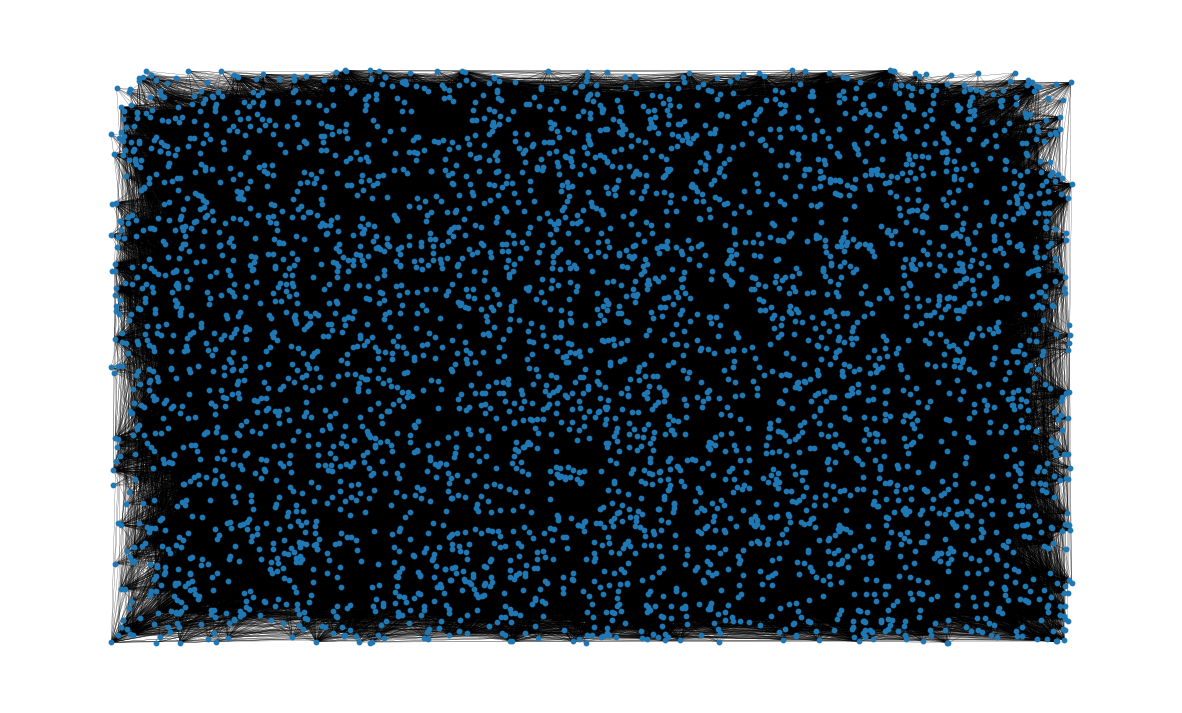

In [4]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

La imagen resultante es... No es muy útil. Visualizaciones gráficas de este tipo a veces se les conoce coloquialmente como "bolas de pelo" debido a la superposición de bordes que resultan en una malla enredada.

Está claro que necesitamos imponer más estructura en el posicionamiento del si. Queremos tener una idea de los datos. Para esto, podemos usar la función  `spring_layout` que es la función de diseño predeterminada para el módulo de dibujo networkx.
La función `spring_layout` tiene la ventaja de que tiene en cuenta los nodos y bordes para calcular las ubicaciones de los nodos. Sin embargo, la desventaja es que este proceso es mucho más costoso computacionalmente, y puede ser bastante Lento para grafos con 100 nodos y 1000 bordes.

Dado que nuestro conjunto de datos tiene más de 80k bordes, limitaremos el número de iteraciones utilizado en la función `spring_layout` para reducir el tiempo de cálculo. También guardaremos el diseño calculado para que podamos usarlo en el futuro. Visualizaciones.

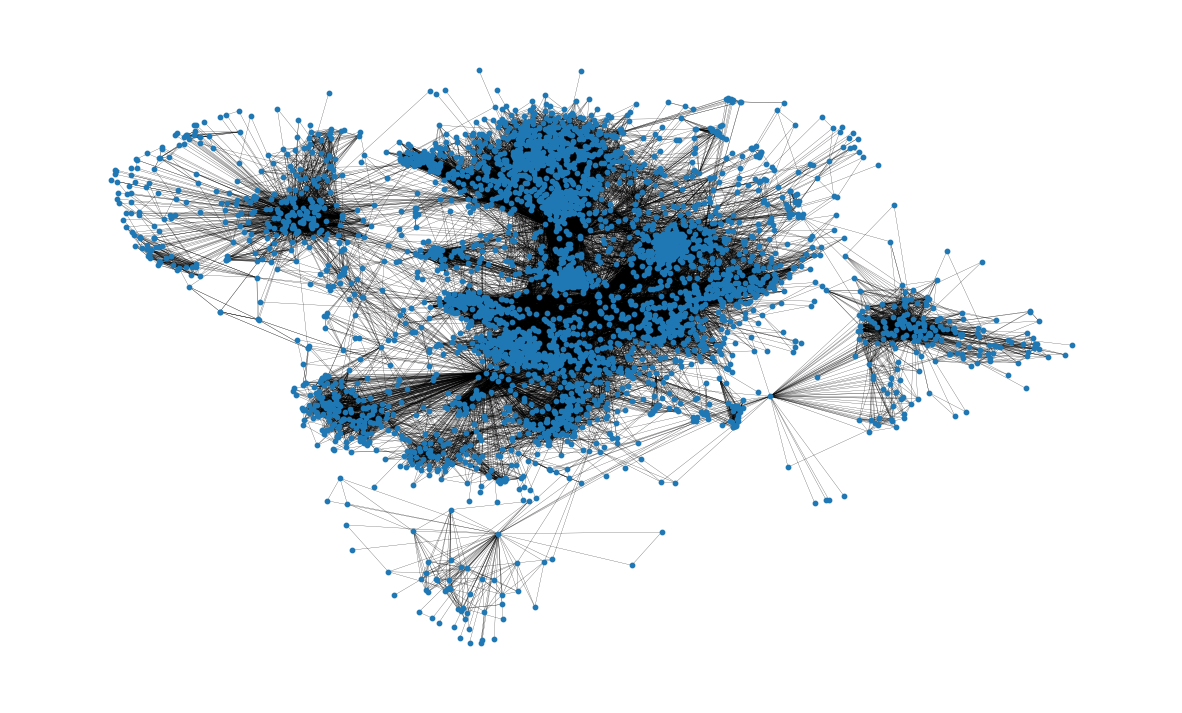

In [5]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

¡Esta visualización es mucho más útil que la anterior! Ya podemos recoger algo sobre la estructura de la red; Por ejemplo, muchos de los Los nodos parecen estar altamente conectados, como podríamos esperar para una red social. También tenemos la sensación de que los nodos tienden a formar clústeres.  El `spring_layout` sirve para dar un sentido cualitativo de agrupamiento, pero no está diseñado para Análisis de agrupamiento cualitativo y repetible. Revisaremos la evaluación Agrupación en clústeres de red [más adelante en el análisis](#Efectos-de-agrupación-en-clústeres)

## Atributos topológicos básicos
* Número total de nodos en la red:

In [6]:
G.number_of_nodes()

4039

* Número total de aristas:

In [7]:
G.number_of_edges()

88234

Además, se puede ver el grado promedio de un nodo.

* En promedio, un nodo está conectado a casi otros 44 nodos, también conocidos como vecinos del nodo.
* Esto se ha calculado creando una lista de todos los grados de los nodos y utilizando `numpy.array` para encontrar la media de la lista creada.

In [8]:
np.mean([d for _, d in G.degree()])

43.69101262688784

Hay muchas propiedades interesantes relacionadas con la distribución de caminos a través del gráfico. Por ejemplo, el diámetro de un gráfico representa el más largo de los rutas más cortas que conectan cualquier nodo con otro nodo del gráfico. Del mismo modo, la longitud media de la ruta da una medida del número medio de bordes que se van a recorrer para ir de un nodo a otro en la red.
Estos atributos se pueden calcular con las funciones `nx.diameter` y`nx.average_shortest_path_length` respectivamente. Sin embargo, tenga en cuenta que estos análisis requieren calcular el camino más corto entre Cada par de nodos en la red: esto puede ser bastante costoso para las redes de este tamaño! Ya que estamos interesados en varios análisis que involucran la longitud de ruta más corta Para todos los nodos de la red, podemos calcular esto una vez y reutilizar la Información para ahorrar tiempo de cálculo.

Comencemos calculando la longitud de ruta más corta para todos los pares de nodos en el red:

In [9]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

`nx.all_pairs_shortest_path_length` Devuelve un dictado de dictado que asigna un nodo a todos los demás nodos de la red, donde la asignación más interna devuelve el longitud de la ruta más corta entre los dos nodos.
En otras palabras, `shortest_path_lengths[u][v]` devolverá la longitud del camino más corto entre dos pares cualesquiera de nodos `u` y `v`:

In [10]:
shortest_path_lengths[0][42]  # Length of shortest path between nodes 0 and 42

1

Ahora vamos a utilizar `shortest_path_lengths` para realizar nuestros análisis, empezando por el diámetro de `G`.
Si miramos cuidadosamente el [docstring for `nx.diameter`][nx_diameter_], vemos que es equivalente a la excentricidad máxima del gráfico.
Resulta que `nx.eccentricity` tiene un argumento opcional `sp` donde podemos pasar nuestro pre-calculo `shortest_path_lengths` para guardar el cálculo adicional:

In [11]:
# Esto es equivalente a `diameter = nx.diameter(G), pero no es más eficiente cuando nosostros reusamos
# el precalculo corto en la longitud de la ruta!
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())
diameter

8

[nx_diameter_](https://networkx.org/documentation/latest/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html)

Para conectarnos de un nodo a cualquier otro tendríamos que atravesar 8 bordes o menos.

A continuación, se encuentra la longitud promedio de la ruta.
Una vez más, podríamos usar `nx.average_shortest_path_length` para calcular esto directamente, pero es mucho más eficiente usar `shortest_path_length` el cual ya hemos calculado:

In [12]:
# Calcular la longitud de la ruta del promedio corto para cada nodo
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# El promedio sobre todos los nodos
np.mean(average_path_lengths)

3.691592636562027

Esto representa el promedio de la longitud de ruta más corta para todos los pares de nodos: Para llegar de un nodo a otro, aproximadamente 3,6 bordes serán atravesado en promedio.

Las medidas anteriores capturan información útil sobre la red, pero métricas como el valor promedio representa sólo un momento de la distribución; Lo es También a menudo es valioso mirar la distribución en sí. De nuevo, podemos construir una visualización de la distribución del camino más corto Longitudes de nuestros dictados precalculados:

Text(0, 0.5, 'Frequency (%)')

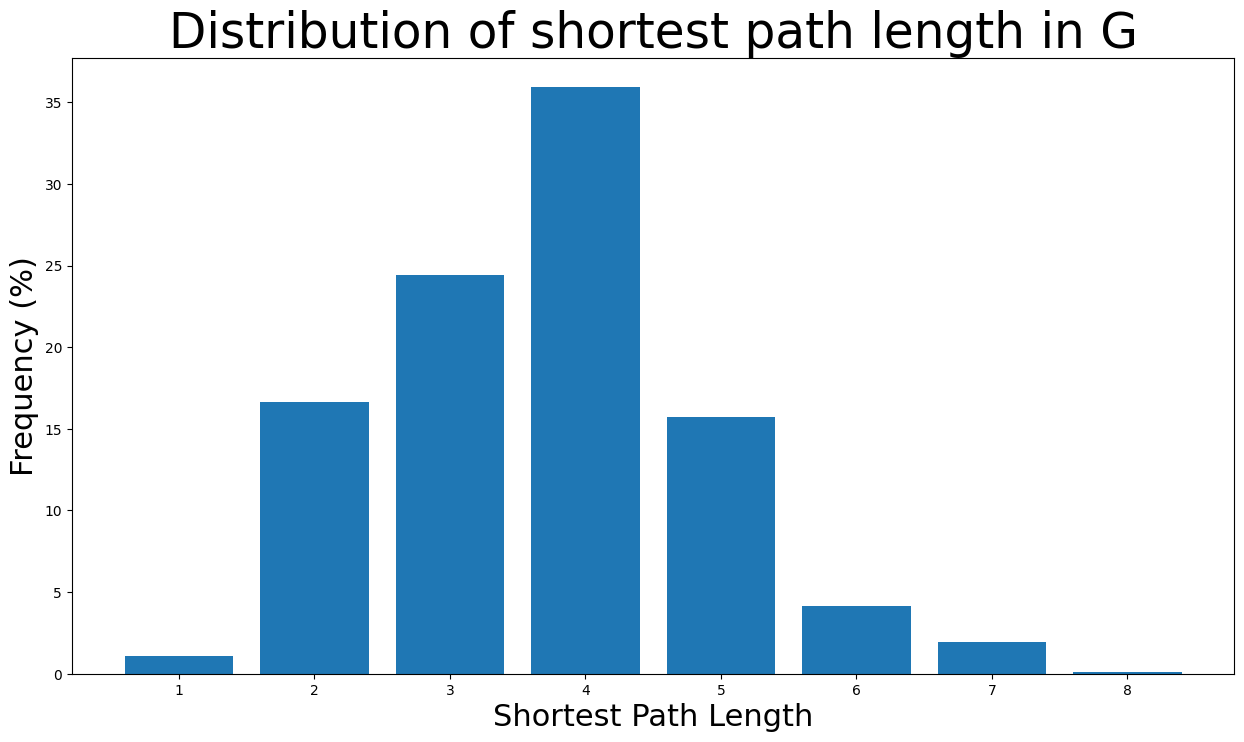

In [13]:
# Conocemos la longitud maxima más corta (El diámetro), asi qeu creamos una vector
# para guardar los valores desde 0 arriba del (e includyendo) diametro
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extraemos la frecuencia de corte entre los dos nodos
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Mostramos la distribución de la frecuencia como un porcentaje (ignorando la longitud de 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Gráficamos la distribución de la frecuencia (ignorando la longitud de 0) como un porcentaje
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    "Distribution of shortest path length in G", fontdict={"size": 35}, loc="center"
)
ax.set_xlabel("Shortest Path Length", fontdict={"size": 22})
ax.set_ylabel("Frequency (%)", fontdict={"size": 22})

La mayoría de las longitudes de camino más cortas son de hasta bordes de largo. Además, es muy poco probable que un par de nodos tenga una ruta más corta de longitud 8 (longitud de diámetro) ya que la probabilidad es inferior al %.
$250.1$.

* La densidad del gráfico se calcula aquí. Claramente, el gráfico es muy escaso ya que: $density < 1$

In [14]:
nx.density(G)

0.010819963503439287

* El número de componentes del gráfico se encuentra a continuación. Como era de esperar, la red consta de un compoenent gigante:

In [18]:
nx.number_connected_components(G)

1

## Medidas de centralidad
Ahora se examinarán las medidas de centralidad para el gráfico de facebook

### Grado Centralidad
La centralidad de grado asigna una puntuación de importancia basada simplemente en el número de enlaces que posee cada nodo. En este análisis, eso significa que cuanto mayor es el grado de centralidad de un nodo, más bordes están conectados al nodo en particular y, por lo tanto, más nodos vecinos (amigos de Facebook) tiene este nodo. De hecho, el grado de centralidad de un nodo es la fracción de nodos a los que está conectado. En otras palabras, es el porcentaje de la red a la que está conectado el nodo en particular, lo que significa ser amigo de.

* A partir de entonces, encontramos los nodos con las centralidades de mayor grado. Específicamente, los nodos con las 8 centralidades de grado más alto se muestran a continuación junto con la centralidad de grado:

In [19]:
degree_centrality = nx.centrality.degree_centrality(
    G
)  # guarda los resultados en una variable para su posterior uso
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(107, 0.258791480931154),
 (1684, 0.1961367013372957),
 (1912, 0.18697374938088163),
 (3437, 0.13546310054482416),
 (0, 0.08593363051015354),
 (2543, 0.07280832095096582),
 (2347, 0.07206537890044576),
 (1888, 0.0629024269440317)]

Eso significa que el nodo $107$ tiene el mayor grado de centralidad con $0.259$, mlo que significa que este usuario de Facebook es amigo de alrededor del 26% de toda la red. Del mismo modo, los nodos $1684, 1912, 3437$ y $0$  también tienen centralidades de muy alto grado.  Sin embargo, eso es bien esperado ya que esos nodos son aquellos cuyos círculos de Facebook examinamos. Muy interesante es el hecho de que los nodos $2543, 2347, 1888$ tienen algunas de las 8 centralidades de mayor grado a pesar de que no investigamos sus círculos. En otras palabras, esos tres nodos son muy populares entre los círculos que examinamos ahora, lo que significa que tienen la mayoría de los amigos de Facebook dentro de esta red, aparte de los nodos destacados.

* Ahora también podemos ver el número de vecinos para los nodos con las centralidades de mayor grado:

In [20]:
(sorted(G.degree, key=lambda item: item[1], reverse=True))[:8]

[(107, 1045),
 (1684, 792),
 (1912, 755),
 (3437, 547),
 (0, 347),
 (2543, 294),
 (2347, 291),
 (1888, 254)]

Como era de esperar, el node $107$ tiene $1045$ amigos de Facebook, que es lo máximo que cualquier usuario de Facebook tiene en este análisis. Además, los nodos,$1684$ y $1912$ tener más de $750$ amigos de facebook en esta red. Además, los nodos $3437$ y $0$ tienen el siguiente mayor número de amigos de Facebook en esta red con $547$ y $347$ respectivamente. Por último, los dos amigos más populares de los nodos de spotlight tienen $290$ amigos alrededor de facebook en esta red.


Ahora se trazará la distribución de las centralidades de grado:

Text(0, 0.5, 'Counts')

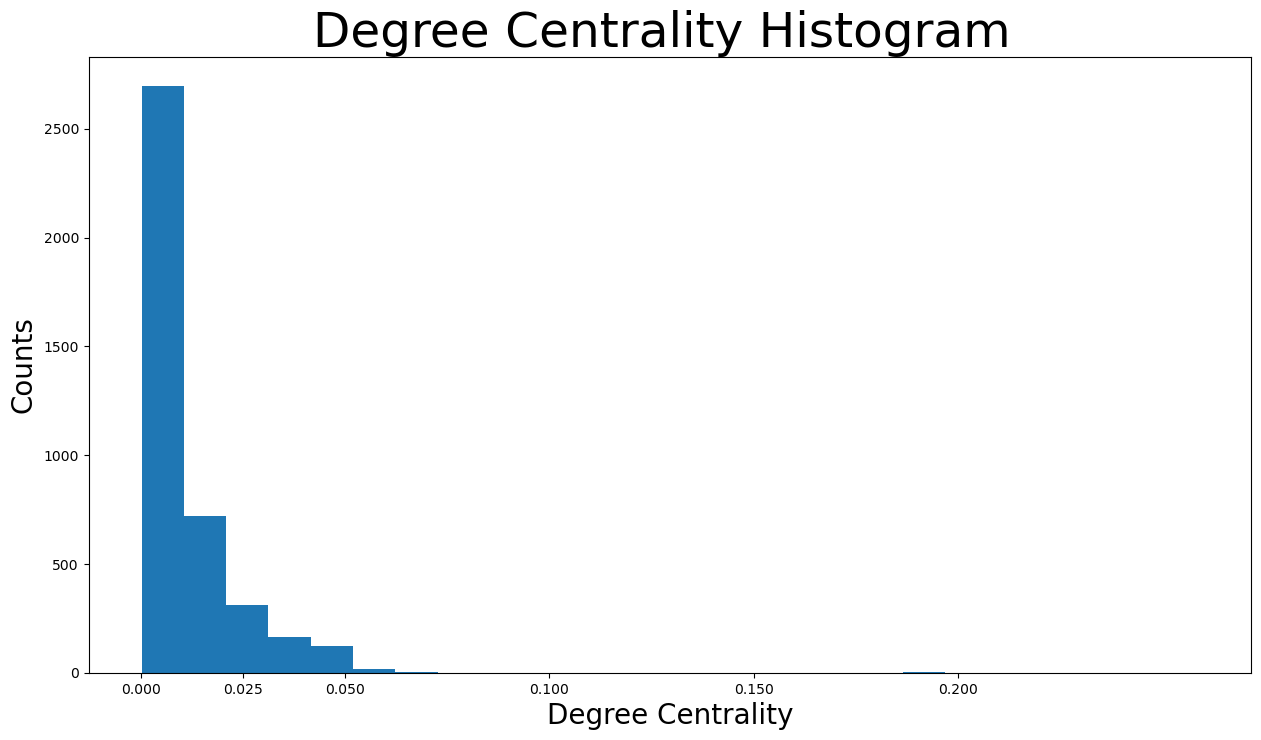

In [21]:
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

Es visible que la gran mayoría de los usuarios de Facebook tienen centralidades de grado de menos de $0.05$. De hecho, la mayoría tiene menos de $0.0125$.  En realidad, eso tiene sentido porque la red consiste en listas de amigos de nodos particulares, que obviamente son los que tienen las centralidades de mayor grado. En otras palabras, debido a que solo se utilizó la lista de amigos de nodos particulares para crear esta red en particular, muchos nodos tienen centralidades de grado extremadamente bajo, ya que no están muy interconectados en esta red.

Ahora vamos a comprobar los usuarios con centralidades de mayor grado del tamaño de sus nodos:

(-0.9991880235075951,
 1.1078363832831382,
 -1.164599134027958,
 0.7322099342942238)

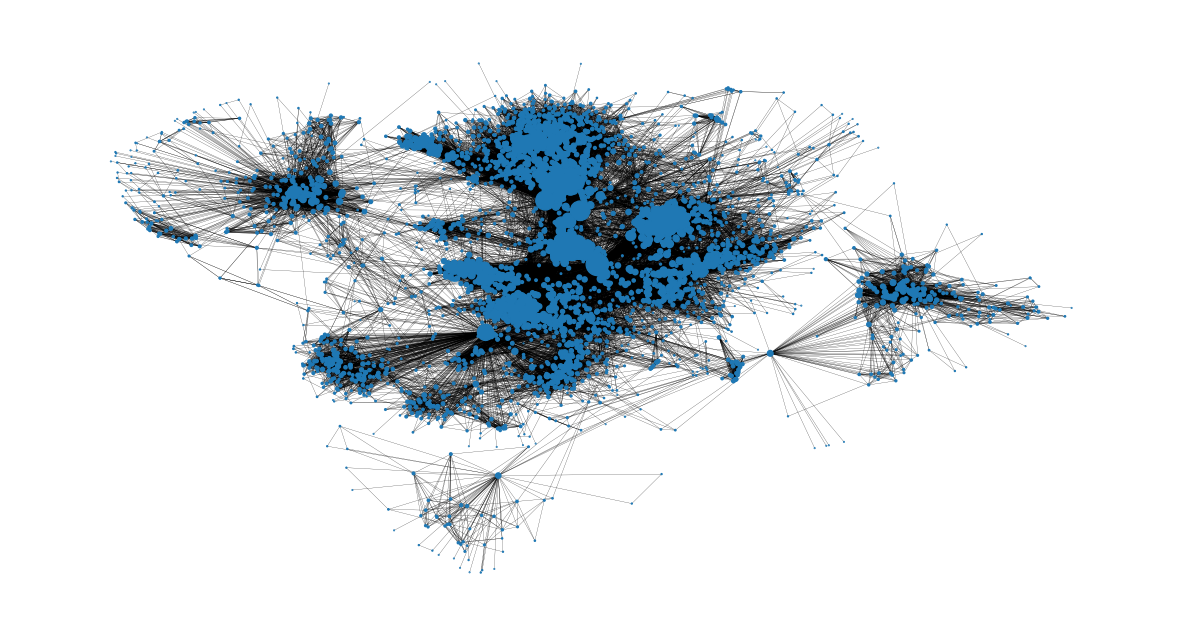

In [22]:
node_size = [
    v * 1000 for v in degree_centrality.values()
]  # configura el tamaño de los nodos para una buena representaión gráfica
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Betweenness Centralidad
La centralidad intermedia mide el número de veces que un nodo se encuentra en el camino más corto entre otros nodos, lo que significa que actúa como un puente.  En detalle, la centralidad intermedia de un nodo $v$ es el porcentaje de todos los caminos más cortos de dos nodos cualesquiera (aparte de $v$), que pasan a través de $v$. Específicamente, en el gráfico de facebook esta medida se asocia con la capacidad del usuario para influir en los demás. Un usuario con una alta centralidad intermedia actúa como un puente para muchos usuarios que no son amigos y, por lo tanto, tiene la capacidad de influir en ellos transmitiendo información (por ejemplo, publicando algo o compartiendo una publicación) o incluso conectarlos a través del círculo del usuario (lo que reduciría la centralidad intermedia del usuario después).
* Ahora, los nodos con las $8$ centralidades de intermediación más altas se calcularán y mostrarán con sus valores de centralidad:

In [23]:
betweenness_centrality = nx.centrality.betweenness_centrality(
    G
)  # guarda los resultados en una variable para su uso posterior
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(107, 0.4805180785560152),
 (1684, 0.3377974497301992),
 (3437, 0.23611535735892905),
 (1912, 0.2292953395868782),
 (1085, 0.14901509211665306),
 (0, 0.14630592147442917),
 (698, 0.11533045020560802),
 (567, 0.09631033121856215)]

En cuanto a los resultados, el nodo $107$ tiene una centralidad intermedia de $0.48$, lo que significa que se encuentra en casi la mitad del total de caminos más cortos entre otros nodos. También, combinando el conocimiento de la centralidad del grado:
* Los Nodos $0, 107, 1684, 1912, 3437$ tienen el grado más alto y las centralidades intermedias y son `spotlight nodes`. Eso indica que esos nodos son los más populares en esta red y también pueden influir y difundir información en la red. Sin embargo, esos son algunos de los nodos cuya lista de amigos consiste en la red y, como resultado, es un hallazgo esperado.
* Los Nodos $567, 1085$ no son nodos destacados, tienen algunas de las centralidades intermedias más altas y no tienen las centralidades de mayor grado. Eso significa que aunque esos nodos no son los usuarios más populares en la red, tienen la mayor influencia en esta red entre los amigos de los nodos destacados cuando se trata de difundir información.
* El Nodo $698$ es un `spotlight node` y tiene una centralidad de intermediación muy alta a pesar de que no tiene las centralidades de grado más alto. En otras palabras, este nodo no tiene una lista de amigos muy grande en Facebook. Sin embargo, toda la lista de amigos del usuario es parte de la red y, por lo tanto, el usuario podría conectar diferentes círculos en esta red siendo el intermediario.

Continuando, se trazará la distribución de las centralidades intermedias:

Text(0, 0.5, 'Counts')

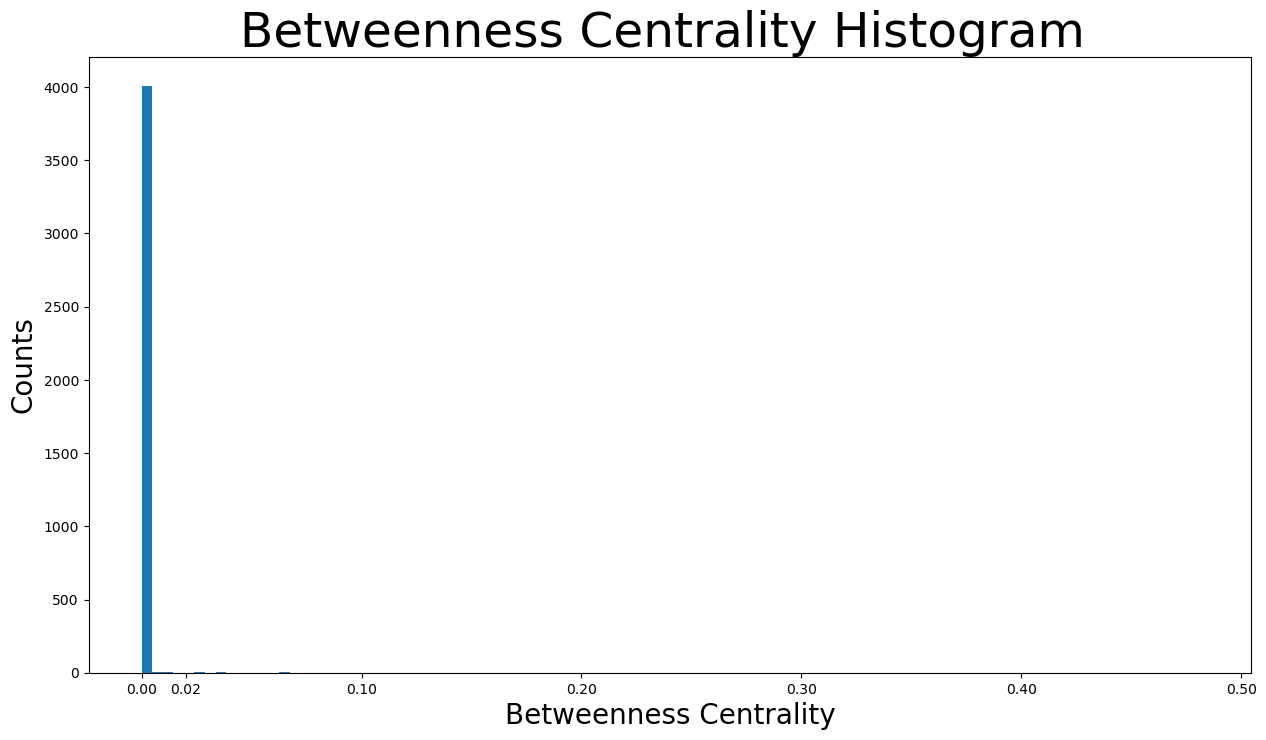

In [24]:
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=100)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])  # set the x axis ticks
plt.title("Betweenness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Betweenness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

Como podemos ver, la gran mayoría de las centralidades intermedias están por debajo de $0.01$. Eso tiene sentido ya que el gráfico es muy escaso y, por lo tanto, la mayoría de los nodos no actúan como puentes en los caminos más cortos. Sin embargo, eso también da como resultado que algunos nodos tengan centralidades de intermediación extremadamente altas, como por ejemplo el nodo $107$ con $0.48$ y el nodo $1684$ con $0.34$ de centralidad de intermediación.

También podemos obtener una imagen sobre los nodos con las centralidades de intermediación más altas y dónde se encuentran en la red. Está claro que son los puentes de una comunidad a otra:

(-0.9991880235075951,
 1.1078363832831382,
 -1.164599134027958,
 0.7322099342942238)

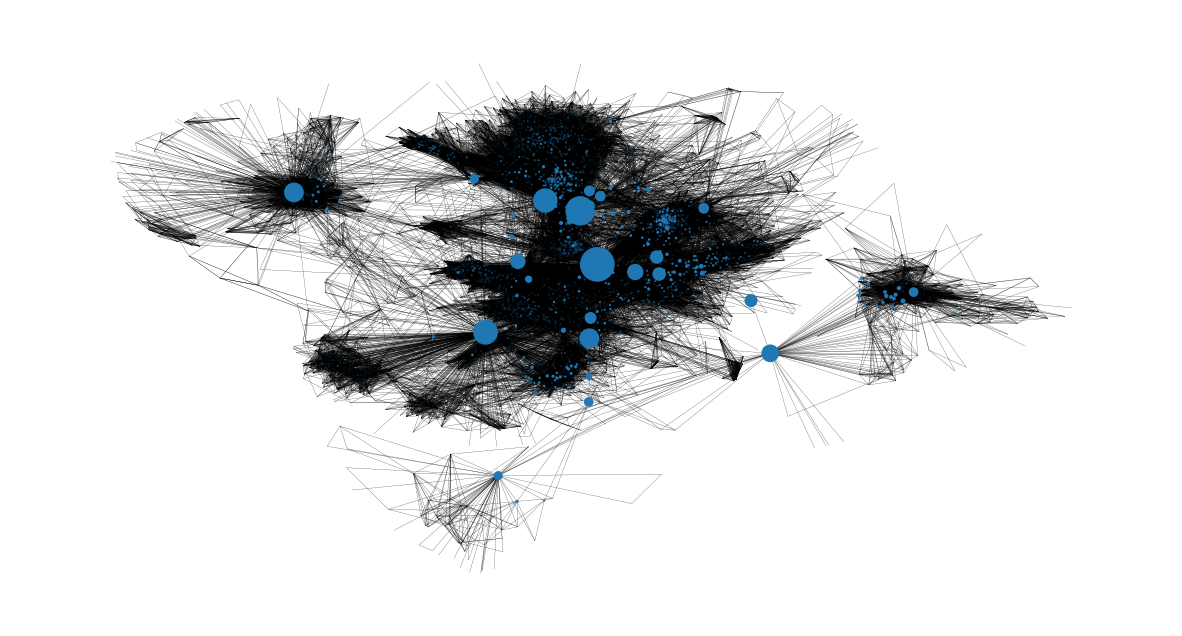

In [25]:
node_size = [
    v * 1200 for v in betweenness_centrality.values()
]  # Configura el tamaño de los nodos para una buena representaión gráfica
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Cercanía Centralidad
La centralidad de cercanía califica cada nodo en función de su "cercanía" a todos los demás nodos de la red. Para un nodo $v$, su centralidad de cercanía mide la lejanía promedio a todos los demás nodos.  En otras palabras, cuanto mayor sea la centralidad de cercanía de $v$, más cerca se encuentra del centro de la red.

La medida de centralidad de cercanía es muy importante para el monitoreo de la propagación de información falsa (por ejemplo, noticias falsas) o virus (por ejemplo, enlaces maliciosos que obtienen el control de la cuenta de Facebook en este caso). Examinemos el ejemplo de las noticias falsas. Si el usuario con la medida de centralidad de cercanía más alta comenzara a difundir información de noticias falsas (compartir o crear una publicación), toda la red se perdería informada lo más rápido posible. Sin embargo, si un usuario con muy baja centralidad de cercanía intentara lo mismo, la difusión de la información errónea a toda la red sería mucho más lenta. Esto se debe a que la información falsa tendría que llegar primero a un usuario con alta centralidad de cercanía que la extendería a muchas partes diferentes de la red.

* Los nodos con las centralidades de cercanía más altas se encontrarán ahora:

In [26]:
closeness_centrality = nx.centrality.closeness_centrality(
    G
)  # guarda los resultados en una variable para su uso posterior
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(107, 0.45969945355191255),
 (58, 0.3974018305284913),
 (428, 0.3948371956585509),
 (563, 0.3939127889961955),
 (1684, 0.39360561458231796),
 (171, 0.37049270575282134),
 (348, 0.36991572004397216),
 (483, 0.3698479575013739)]

Inspeccionando a los usuarios con las mayores centralidades de cercanía, entendemos que no hay una gran brecha entre ellos en contraste con las métricas anteriores. Además, los nodos $107, 1684, 348$ son los únicos `spotlight nodes` que se encuentran en los que tienen las centralidades de cercanía más altas. Eso significa que un nodo que tiene muchos amigos no es necesario cerca del centro de la red.

Además, la distancia promedio de un nodo en particular a cualquier otro nodo se puede encontrar fácilmente con la fórmula:

$$\frac{1}{closeness\,centrality(v)}$$

In [27]:
1 / closeness_centrality[107]

2.1753343239227343

La distancia del nodo $107$ a un nodo aleatorio es de alrededor de dos saltos

Además, la distribución de las centralidades de cercanía:

Text(0, 0.5, 'Counts')

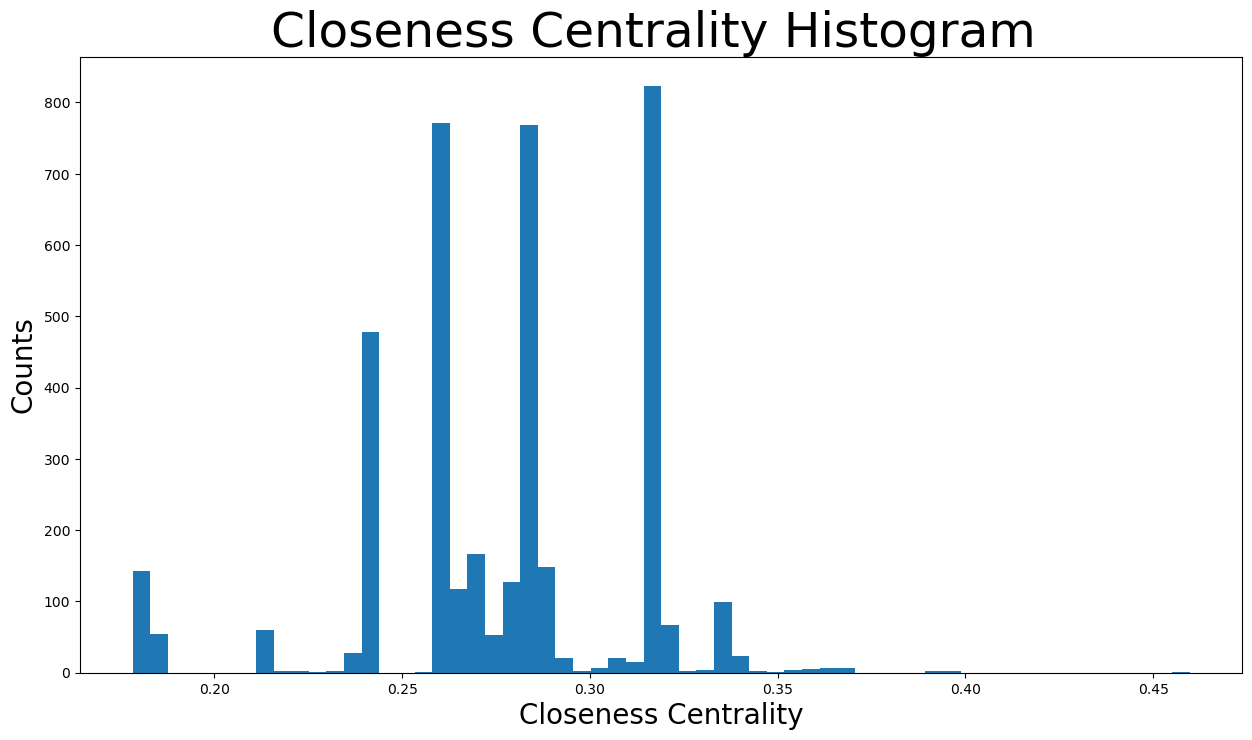

In [28]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title("Closeness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Closeness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

Las centralidades de cercanía se distribuyen en varios valores desde $0.17$ a $0.46$. De hecho, la mayoría de ellos se encuentran entre $0.25$ y $0.3$. T Eso significa que la mayoría de los nodos están relativamente cerca del centro de la red y, por lo tanto, cerca de otros nodos en general. Sin embargo, hay algunas comunidades que se encuentran más lejos, cuyos nodos tendrían las centralidades mínimas de cercanía, como se ve a continuación:

(-0.9991880235075951,
 1.1078363832831382,
 -1.164599134027958,
 0.7322099342942238)

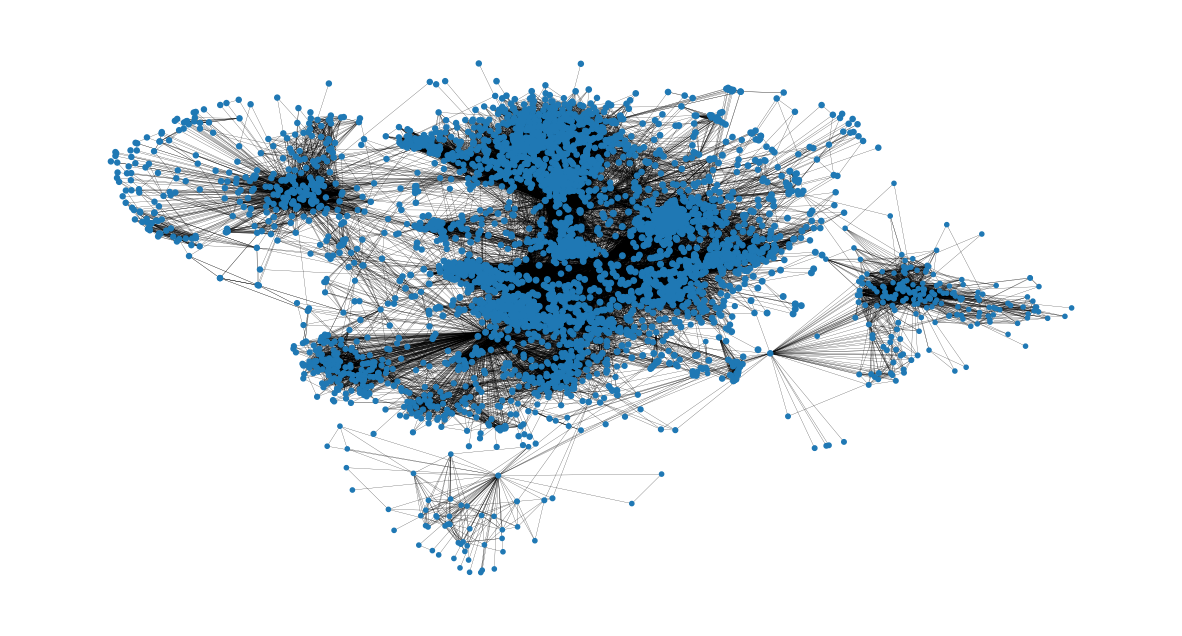

In [29]:
node_size = [
    v * 50 for v in closeness_centrality.values()
]  # visualización
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Centralidad del vector propio
La centralidad del vector propio es la métrica para mostrar qué tan conectado está un nodo a otros nodos importantes de la red. Mide la influencia de un nodo en función de qué tan bien está conectado dentro de la red y cuántos enlaces tienen sus conexiones, etc. Esta medida puede identificar los nodos con mayor influencia sobre toda la red. Una alta centralidad de vector propio significa que el nodo está conectado a otros nodos que tienen centralidades de vectores propios altas. En este análisis de Facebook, la medida se asocia con la capacidad de los usuarios para influir en todo el gráfico y, por lo tanto, los usuarios con las centralidades de vectores propios más altas son los nodos más importantes de esta red.

* Los nodos con las centralidades de vectores propios más altas se examinarán ahora:

In [30]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(
    G
)  # Guarda en una variabla para su posterior uso
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[(1912, 0.09540696149067629),
 (2266, 0.08698327767886552),
 (2206, 0.08605239270584342),
 (2233, 0.08517340912756598),
 (2464, 0.08427877475676092),
 (2142, 0.08419311897991796),
 (2218, 0.0841557356805503),
 (2078, 0.08413617041724979),
 (2123, 0.08367141238206226),
 (1993, 0.0835324284081597)]

Comprobación de los resultados:
* El Nodo $1912$ tiene la centralidad de vector propio más alta con $0.095$. Este nodo también es  `spotlight node` y seguramente puede considerarse el nodo más importante de esta red en términos de influencia general para toda la red. De hecho, este nodo también tiene algunas de las centralidades de mayor grado y centralidades intermedias, lo que hace que el usuario sea muy popular e influyente para otros nodos.
* Los Nodos $1993, 2078, 2206, 2123, 2142, 2218, 2233, 2266, 2464$, aunque no son nodos de foco, tienen algunas de las centralidades de vectores propios más altas con alrededor de $0.83-0.87$. Muy interesante es el hecho de que todos esos nodos se identifican por primera vez, lo que significa que no tienen ni el grado más alto, la intermediación o las centralidades de cercanía en este gráfico. Esto lleva a la conclusión de que es muy probable que esos nodos estén conectados al nodo $1912$ y, como resultado, tienen centralidades de vectores propios muy altas.

Comprobando si esos nodos están conectados al nodo más importante $1912$, la hipótesis es correcta:


In [31]:
high_eigenvector_centralities = (
    sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)
)[
    1:10
]  # 2nd y 10th nodos con alta eigenvector centralities
high_eigenvector_nodes = [
    tuple[0] for tuple in high_eigenvector_centralities
]  # configura la lista como [2266, 2206, 2233, 2464, 2142, 2218, 2078, 2123, 1993]
neighbors_1912 = [n for n in G.neighbors(1912)]  # list with all nodes connected to 1912
all(
    item in neighbors_1912 for item in high_eigenvector_nodes
)  # chequea si los items en la lista high_eigenvector_nodes existen en la lista neighbors_1912

True

Veamos la distribución de las centralidades del vector propio:

Text(0, 0.5, 'Counts')

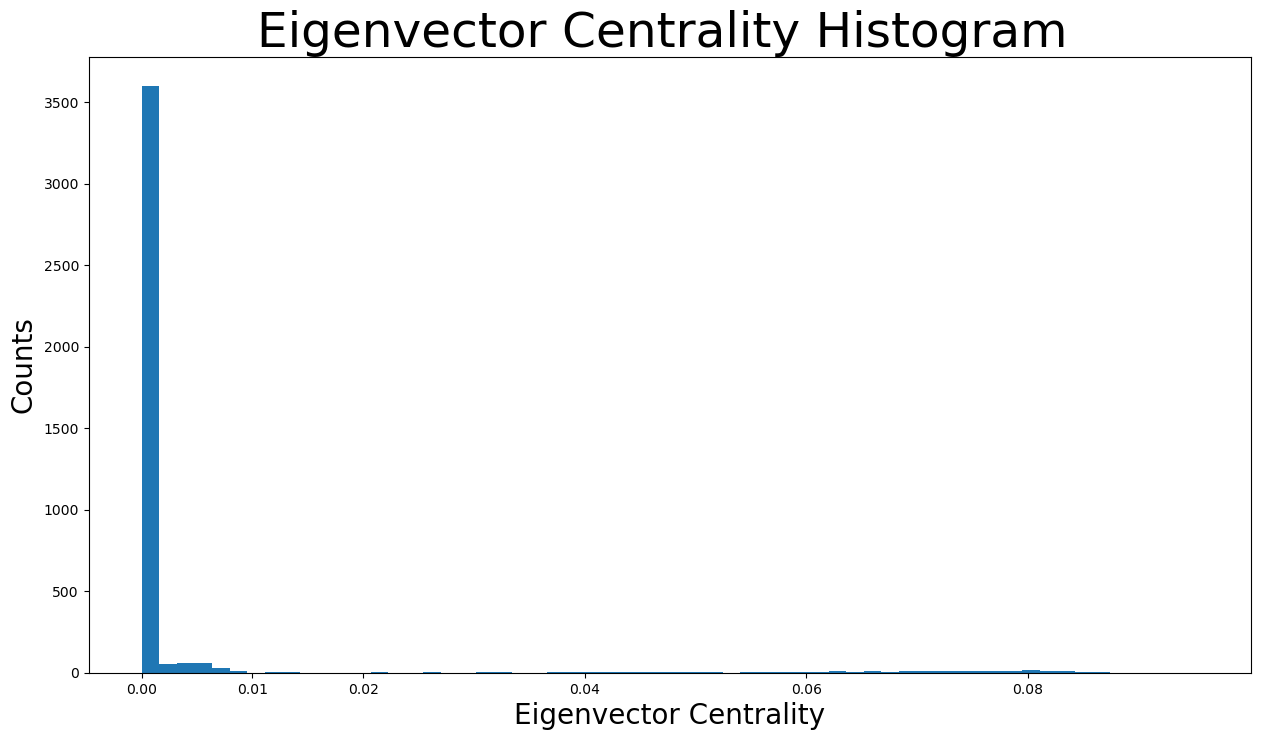

In [32]:
plt.figure(figsize=(15, 8))
plt.hist(eigenvector_centrality.values(), bins=60)
plt.xticks(ticks=[0, 0.01, 0.02, 0.04, 0.06, 0.08])  # set the x axis ticks
plt.title("Eigenvector Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Eigenvector Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

Como se muestra en el histograma de distribución, la gran mayoría de las centralidades del vector propio están por debajo de $0.005$ y en realidad son casi $0$. Sin embargo, también podemos ver diferentes valores de centralidades de vectores propios, ya que hay pequeños contenedores en todo el eje x

Ahora podemos identificar las centralidades del vector propio de los nodos en función de su tamaño en la siguiente representación:

(-0.9991880235075951,
 1.1078363832831382,
 -1.164599134027958,
 0.7322099342942238)

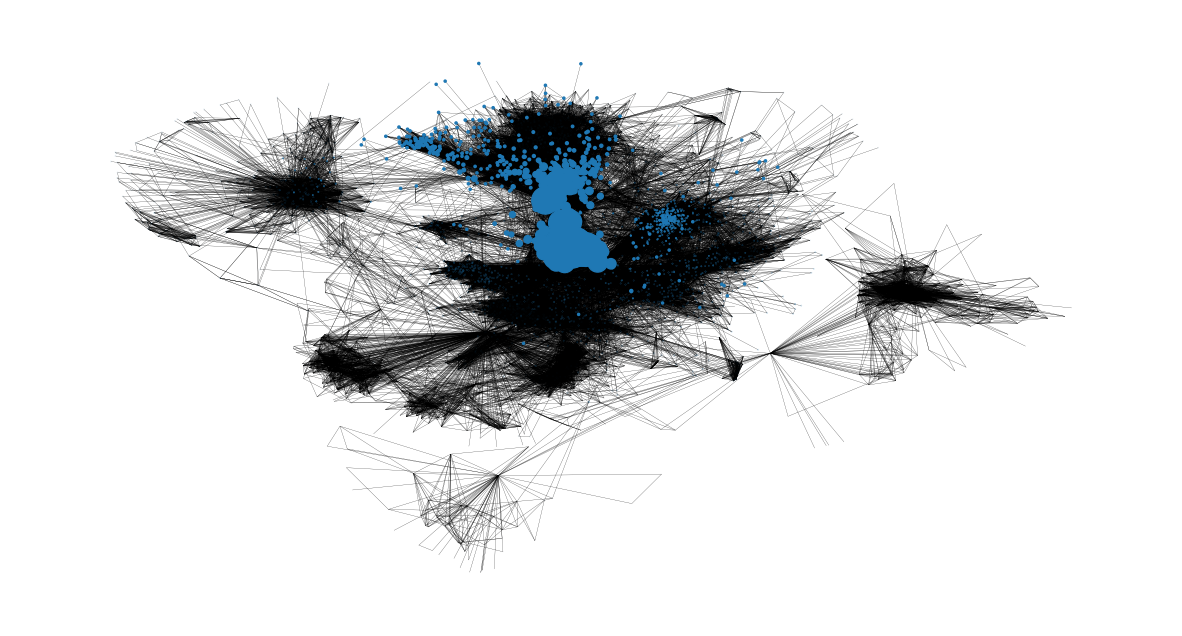

In [33]:
node_size = [
    v * 4000 for v in eigenvector_centrality.values()
]  # Visualización
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

## Efectos de agrupación en clústeres
El coeficiente de agrupamiento de un nodo $v$ se define como la probabilidad de que dos amigos seleccionados al azar de $v$ sean amigos entre sí. Como resultado, el coeficiente de agrupamiento promedio es el promedio de los coeficientes de agrupación de todos los nodos. Cuanto más cerca esté el coeficiente de agrupamiento promedio de $1$, más completo será el gráfico porque solo hay un componente gigante. Por último, es un signo de cierre triádico porque cuanto más completo sea el gráfico, más triángulos generalmente surgirán.


In [34]:
nx.average_clustering(G)

0.6055467186200876

Ahora se mostrará la distribución del coeficiente de agrupación:

Text(0, 0.5, 'Counts')

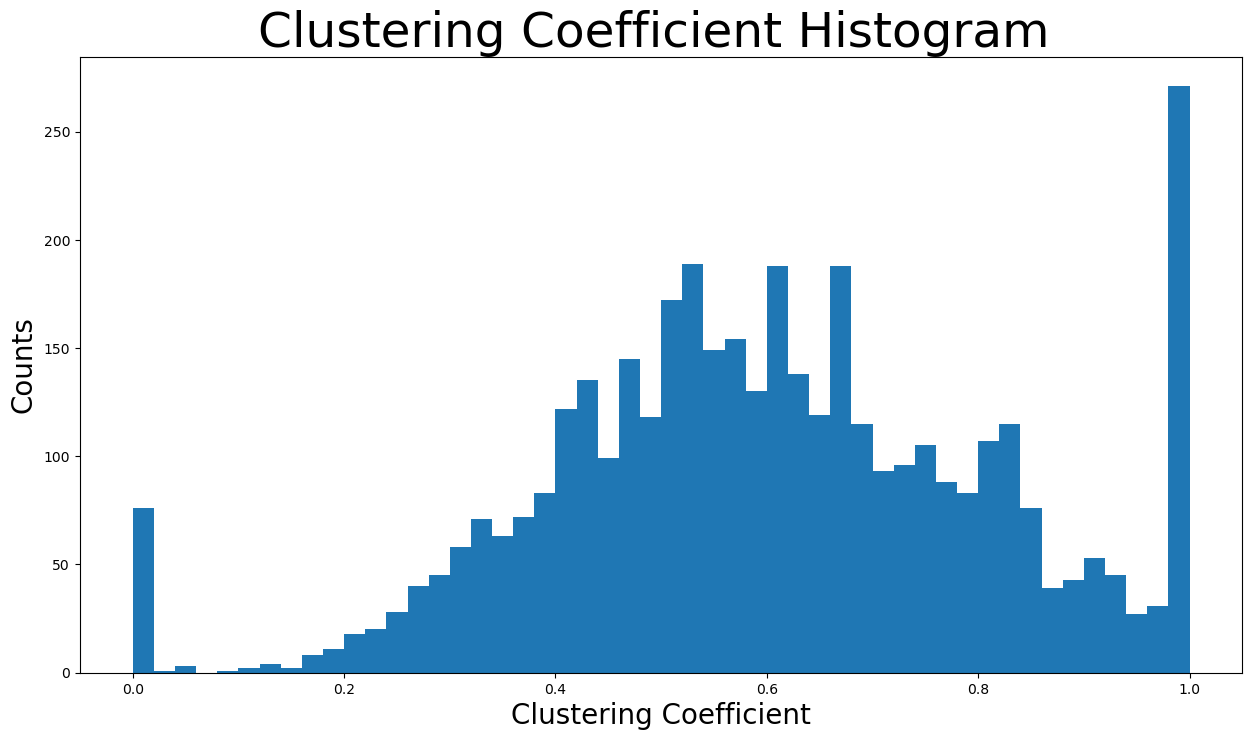

In [35]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(G).values(), bins=50)
plt.title("Clustering Coefficient Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Clustering Coefficient", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

 $50$ bins fueron usados para mostrar la distribución. El bin  con los recuentos más altos se refiere a los nodos con un coeficiente de agrupación cercano a $1$  ya que hay más de doscientos cincuenta nodos en ese bin. Además, los bins de coeficiente de agrupación entre y contienen la mayoría de los nodos con diferencia.
 
 El número de triángulos únicos en la red se encuentra a continuación:

In [36]:
triangles_per_node = list(nx.triangles(G).values())
sum(
    triangles_per_node
) / 3  # divide por 3 por que cada triangulo se cuenta una vez por cada nodo

1612010.0

 Ahora el número promedio de triángulos de los que forma parte un nodo:

In [37]:
np.mean(triangles_per_node)

1197.3334983906907

DDebido a que tenemos algunos nodos que pertenecen a una gran cantidad de triángulos, la métrica de la mediana nos dará una mejor comprensión:

In [38]:
np.median(triangles_per_node)

161.0

De hecho, el valor medio son solo $161$ triangulos, cuando la media está alrededor de $1197$ triangulos de los que forma parte un nodo. Eso significa que la mayoría de los nodos de la red pertenecen a muy pocos triángulos, mientras que algunos nodos son parte de una plétora de triángulos (que son valores extremos que aumentan la media).

En conclusión, el alto coeficiente de agrupamiento promedio junto con el gran número de triángulos son signos del cierre triádico. En detalle, el cierre triádico significa que a medida que pasa el tiempo, tienden a formarse nuevas aristas entre dos usuarios que tienen uno o más amigos en común. Eso puede explicarse por el hecho de que Facebook generalmente sugiere nuevos amigos a un usuario cuando hay muchos amigos mutuos entre el usuario y el nuevo amigo que se agregará. Además, hay una fuente de estrés latente. Por ejemplo, si el nodo $A$ es amigo del nodo $B$ y $C$,  algo de tensión se acumula si  $B$ y $C$ no son amigos entre sí.

## Puentes
En primer lugar, una arista que une dos nodos A y B en el grafo se considera un puente, si eliminar la arista haría que A y B se encuentren en dos componentes diferentes. Ahora se comprueba si hay puentes en esta red:

In [39]:
nx.has_bridges(G)

True

En realidad, hay puentes en la red. Ahora los bordes que son puentes se guardarán en una lista y se imprimirá el número de ellos:

In [40]:
bridges = list(nx.bridges(G))
len(bridges)

75

La existencia de tantos puentes se debe al hecho de que esta red solo contiene los nodos de foco y los amigos de ellos. Como resultado, algunos amigos de los nodos de foco solo están conectados a un nodo de foco, lo que convierte ese borde en un puente.

Además, los bordes que son puentes locales se guardan en una lista y se imprime su número. En detalle, un borde que une dos nodos  $C$ y $D$
en un grafo es un puente local, si sus puntos finales $C$ y $D$ no tienen amigos en común. Muy importante, un borde que es un puente es también un puente local. Por lo tanto, esta lista contiene todos los puentes anteriores también

In [41]:
local_bridges = list(nx.local_bridges(G, with_span=False))
len(local_bridges)

78

Mostrando los puentes y puentes locales en la red ahora. Los puentes se pueden ver con el color rojo y los puentes locales con el color verde. Los bordes negros no son ni puentes locales ni puentes.

* Está claro que todos los puentes se refieren a nodos que solo están conectados a un nodo de foco (tienen un grado de $1$)

(-0.9991880235075951,
 1.1078363832831382,
 -1.164599134027958,
 0.7322099342942238)

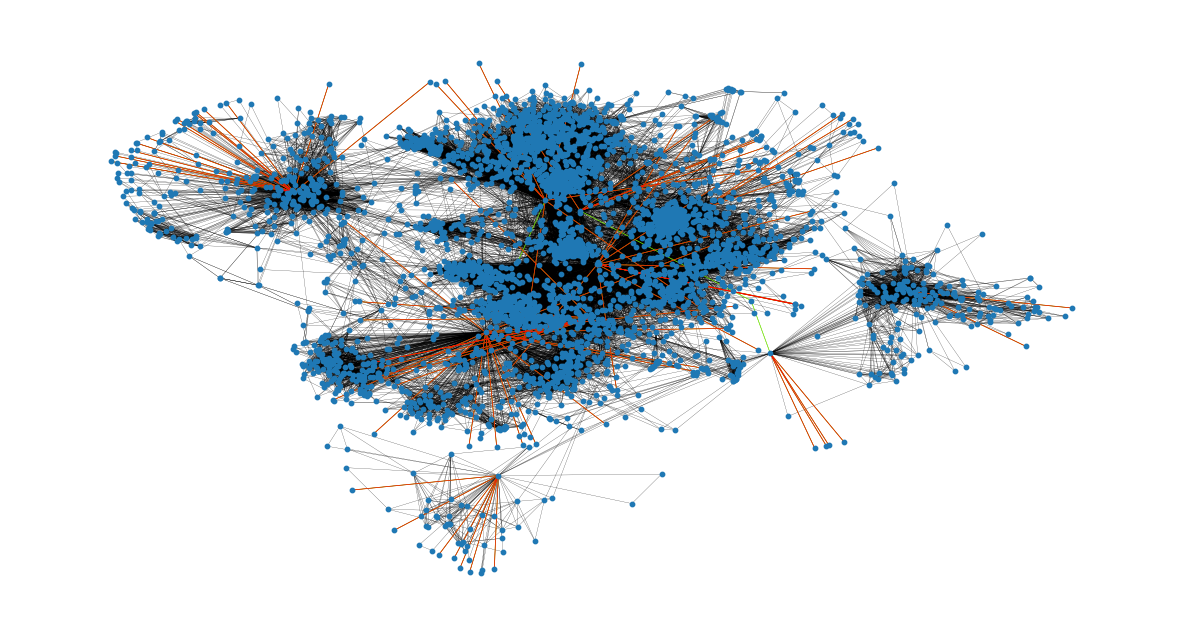

In [42]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(
    G, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
)  # green color for local bridges
nx.draw_networkx_edges(
    G, pos, edgelist=bridges, width=0.5, edge_color="r"
)  # red color for bridges
plt.axis("off")

## Asortatividad
La asortatividad describe la preferencia de que los nodos de una red se conecten a otros que son similares de alguna manera.
* La asortatividad en términos de grados de nodos se encuentra de dos maneras:

In [43]:
nx.degree_assortativity_coefficient(G)

0.06357722918564943

In [44]:
nx.degree_pearson_correlation_coefficient(
    G
)  # use the potentially faster scipy.stats.pearsonr function.

0.06357722918564664

De hecho, el coeficiente de asortatividad es el coeficiente de correlación de Pearson de grado entre pares de nodos enlazados. Eso significa que toma valores de $-1$ a $1$. En detalle, un coeficiente de asortatividad positivo indica una correlación entre nodos de grado similar, mientras que un negativo indica correlación entre nodos de diferentes grados.

En nuestro caso el coeficiente de asortatividad es alrededor de $0.064$, que es casi 0. Eso significa que la red es casi no selectiva, y no podemos correlacionar nodos vinculados en función de sus grados. En otras palabras, no podemos sacar conclusiones sobre el número de amigos de un usuario a partir del número de amigos de sus amigos (grado de amigos). Eso tiene sentido ya que solo usamos la lista de amigos de los nodos de spotlight, los nodos no destacados tenderán a tener muchos menos amigos.


## Comunidades de red
Una comunidad es un grupo de nodos, de modo que los nodos dentro del grupo están conectados con muchas más aristas que entre grupos. Se utilizarán dos algoritmos diferentes para la detección de comunidades en esta red.
* En primer lugar, se utiliza un método de propagación de etiquetas semisincrónico para detectar las comunidades.

Esta función determina por sí misma el número de comunidades que se detectarán. Ahora se iterarán las comunidades y se creará una lista de colores para contener el mismo color para los nodos que pertenecen a la misma comunidad. Además, se imprime el número de comunidades:

In [45]:
colors = ["" for x in range(G.number_of_nodes())]  # initialize colors list
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    counter += 1
    for node in list(
        com
    ):  # fill colors list with the particular color for the community nodes
        colors[node] = color
counter

44

En detalle, se detectaron, $44$ comunidades. Ahora las comunidades se muestran en el gráfico. Cada comunidad se representa con un color diferente y sus nodos generalmente se encuentran cerca uno del otro:

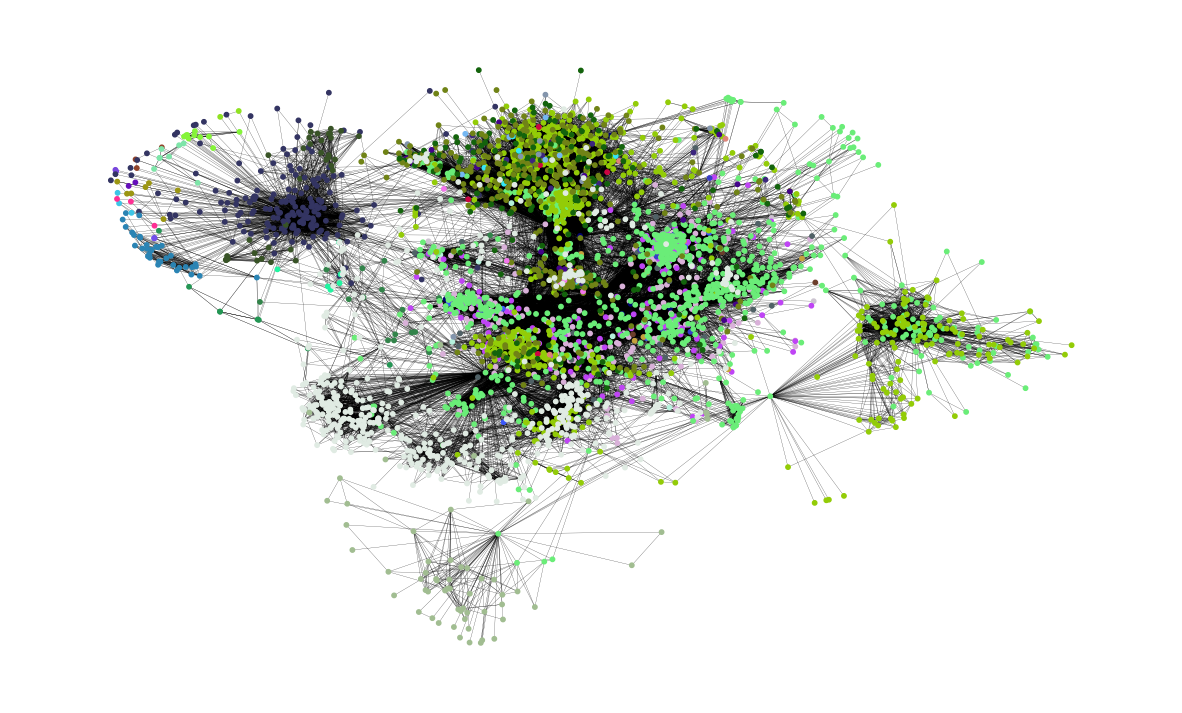

In [46]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)

* A continuación, se utiliza el algoritmo de comunidades fluidas asíncronas.

Con esta función, podemos decidir el número de comunidades a detectar. Digamos que $8$ comunidades es el número que queremos. Una vez más, las comunidades se iterarán y se creará una lista de colores para contener el mismo color para los nodos que pertenecen a la misma comunidad.


In [47]:
colors = ["" for x in range(G.number_of_nodes())]
for com in nx.community.asyn_fluidc(G, 8, seed=0):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    for node in list(com):
        colors[node] = color

Ahora las $8$ comunidades se muestran en el grafo. Una vez más, cada comunidad se representa con un color diferente:


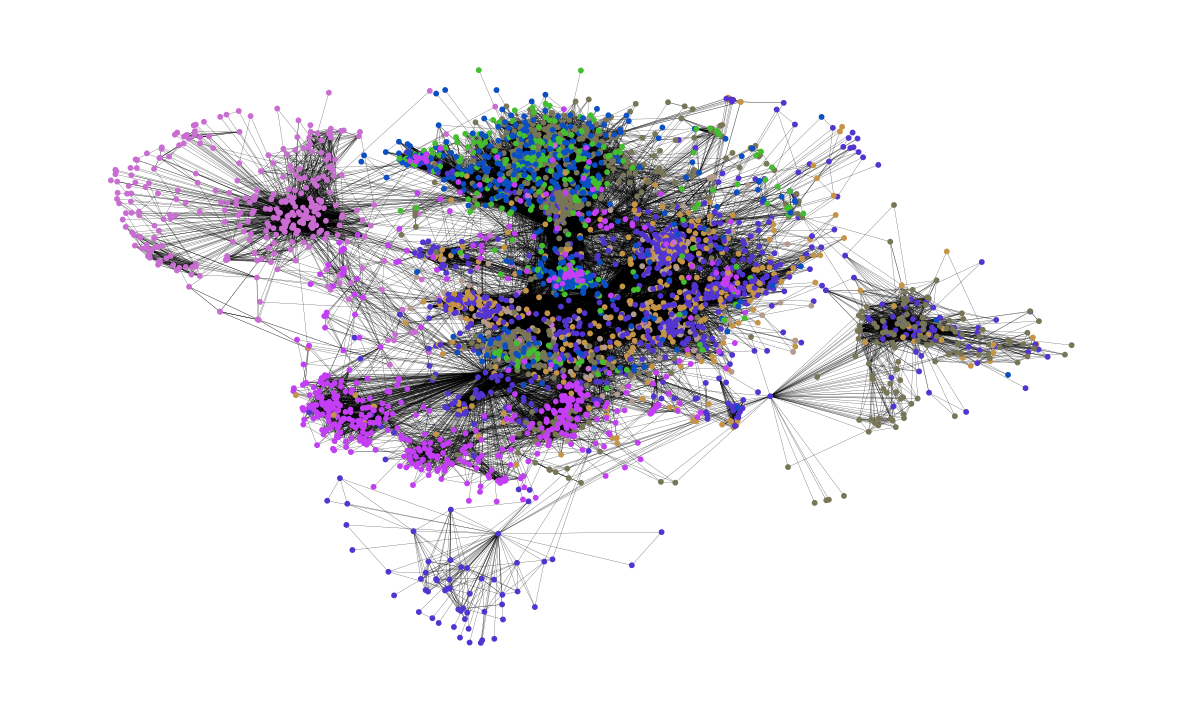

In [48]:
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
)

### References
[Cambridge-intelligence](https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/#:~:text=Centrality%20measures%20are%20a%20vital,but%20they%20all%20work%20differently.)

[^1]: [Semi-synchronous label propagation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.label_propagation.label_propagation_communities.html#networkx.algorithms.community.label_propagation.label_propagation_communities)

[^2]: [Asynchronous fluid communities algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.asyn_fluid.asyn_fluidc.html#networkx.algorithms.community.asyn_fluid.asyn_fluidc)